# Triton Tutorial

## Section 1. Understanding Your GPUs

Welcome to this Triton tutorial. First, let's check whether you have a GPU.

In [1]:
import torch
assert torch.cuda.is_available(), "You don't even have a CUDA-enabled GPU! Please connect to a machine with a GPU."

In [2]:
num_devices = torch.cuda.device_count()
print("How many GPUs do you have?", num_devices)

How many GPUs do you have? 1


In [3]:
for i in range(num_devices):
    print(f"GPU #{i}: {torch.cuda.get_device_properties(i)}")

GPU #0: _CudaDeviceProperties(name='NVIDIA A800-SXM4-80GB', major=8, minor=0, total_memory=81228MB, multi_processor_count=108, uuid=8ceef838-18be-c311-f8ca-50b75831fad1, L2_cache_size=40MB)


Wait... What does this mean? It shows some basic properties about your GPUs.

For example, GPU 0 has the following properties:

In [4]:
def convert_compute_capability_to_cuda_cores_per_sm(cc):
    """
    Python version of _ConvertSMVer2Cores in helper_cuda.h:
    https://github.com/NVIDIA/cuda-samples/blob/3f1c50965017932fc81e6d94a3fc9e04c105b312/Common/helper_cuda.h#L646
    """
    return {
        (3, 0): 192, (3, 2): 192, (3, 5): 192, (3, 7): 192,  # Kepler
        (5, 0): 128, (5, 2): 128, (5, 3): 128,  # Maxwell
        (6, 0): 64, (6, 1): 128, (6, 2): 128,  # Pascal
        (7, 0): 64,  # Volta
        (7, 2): 64,  # Xavier
        (7, 5): 64,  # Turing
        (8, 0): 64, (8, 6): 128, (8, 7): 128,  # Ampere
        (8, 9): 128,  # Ada Lovelace
        (9, 0): 128,  # Hopper
        (10, 0): 128, (10, 1): 128, (10, 3): 128, (11, 0): 128, (12, 0): 128, (12, 1): 128 # Blackwell
    }[cc]

def convert_compute_capability_to_tensor_cores_per_sm(cc):
    """
    According to https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities
    """
    if cc[0] < 7:
        return 0
    elif cc[0] == 7:
        return 8
    elif cc[0] == 8:
        return 4
    elif cc[0] == 9:
        return 4
    elif cc[0] == 10:
        return 4
    else:
        raise NotImplementedError(f"No official number of tensor cores per SM for compute capability {cc[0]}.{cc[1]}")

prop = torch.cuda.get_device_properties(0)

print(f"What is the name of your GPU? {prop.name}")
print(f"How many SMs does it have? {prop.multi_processor_count}")
print(f"What is the version number of your GPU's Compute Capability? {prop.major}.{prop.minor} (see https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities)")
print(f"What is the number of CUDA cores per SM? {convert_compute_capability_to_cuda_cores_per_sm((prop.major, prop.minor))}")
print(f"What is the number of Tensor Cores per SM? {convert_compute_capability_to_tensor_cores_per_sm((prop.major, prop.minor))} (this number is a speculation based on the compute capability)")
print(f"What is the total memory available on the GPU? {prop.total_memory / 1024 ** 3:.2f} GB")
print(f"What is the L2 cache size? {prop.L2_cache_size / 1024 ** 2} MB")

What is the name of your GPU? NVIDIA A800-SXM4-80GB
How many SMs does it have? 108
What is the version number of your GPU's Compute Capability? 8.0 (see https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities)
What is the number of CUDA cores per SM? 64
What is the number of Tensor Cores per SM? 4 (this number is a speculation based on the compute capability)
What is the total memory available on the GPU? 79.33 GB
What is the L2 cache size? 40.0 MB


The clock rate of the GPU is a bit tricky. You will see this from the following code:

In [5]:
import time
time.sleep(15)
print(f"The GPU has been idle for 15 seconds. What is the current clock rate? {torch.cuda.clock_rate(0)} MHz")

def warmup_gpu():
    t = 0
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    foo = torch.empty(10 ** 8, device='cuda:0')
    while t < 1000:
        start.record()
        foo.zero_()
        end.record()
        torch.cuda.synchronize()
        t += start.elapsed_time(end)

warmup_gpu()
print(f"After warmuping up the GPU, what is the current clock rate? {torch.cuda.clock_rate(0)} MHz")

The GPU has been idle for 15 seconds. What is the current clock rate? 210 MHz
After warmuping up the GPU, what is the current clock rate? 1410 MHz


Let's do some napkin math. Please fill in the code below.

In [17]:
total_cuda_cores = prop.multi_processor_count * convert_compute_capability_to_cuda_cores_per_sm((prop.major, prop.minor)) # TODO: please fill in
warmup_gpu()
tflops_per_sec = total_cuda_cores * torch.cuda.clock_rate(0) * 1e6 * 2 / 1e12 # TODO: please fill in

print(f"How many CUDA cores does your GPU have in total?")
print(f"{total_cuda_cores}\n")
print(f"A CUDA core is able to do 1 addition and 1 multiplication per clock cycle (2 FLOPs).\nHow many trillion FLOPs can your GPU do in 1 second with all of its CUDA cores? (round to 2 decimal places)")
print(f"{round(tflops_per_sec, 2)} TFLOPs/s\n")

How many CUDA cores does your GPU have in total?
6912

A CUDA core is able to do 1 addition and 1 multiplication per clock cycle (2 FLOPs).
How many trillion FLOPs can your GPU do in 1 second with all of its CUDA cores? (round to 2 decimal places)
19.49 TFLOPs/s



## Section 2. Vector Addition with Triton

Let's implement the vector addition operation in Triton! Please refer to the lecture slides for the code snippet.

In [7]:
import triton
import triton.language as tl
from src.test_triton import check_same_tensor

@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n, SEGMENT_SIZE: tl.constexpr):
    pid = tl.program_id(axis = 0)
    segment_start = pid * SEGMENT_SIZE
    offsets = segment_start + tl.arange(0, SEGMENT_SIZE)
    mask = offsets < n
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0)
    y = tl.load(y_ptr + offsets, mask=mask, other=0.0)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.is_cuda
    assert x.device == y.device
    assert x.shape == y.shape
    
    n = x.numel()
    grid = lambda meta: (triton.cdiv(n, meta['SEGMENT_SIZE']),)
    add_kernel[grid](x, y, output, n, SEGMENT_SIZE=1024)
    return output


for size in [1, 6, 77, 128, 1024, 8888, 40470, 404705, 40470533]:
    print(f"testing size {size}")
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    output_torch = x + y
    output_triton = add(x, y)
    check_same_tensor(output_torch, output_triton)

testing size 1
✓ Correctness test passed! Max difference: 0.00e+00
testing size 6
✓ Correctness test passed! Max difference: 0.00e+00
testing size 77
✓ Correctness test passed! Max difference: 0.00e+00
testing size 128
✓ Correctness test passed! Max difference: 0.00e+00
testing size 1024
✓ Correctness test passed! Max difference: 0.00e+00
testing size 8888
✓ Correctness test passed! Max difference: 0.00e+00
testing size 40470
✓ Correctness test passed! Max difference: 0.00e+00
testing size 404705
✓ Correctness test passed! Max difference: 0.00e+00
testing size 40470533
✓ Correctness test passed! Max difference: 0.00e+00


Wonderful! You must have passed the test above.

Now, let's use `triton.testing.do_bench` to compare the performance of float16 and float32 vector addition.

**Usage:** `triton.testing.do_bench(fn)` will run the function `fn` for 25ms for warmup, and then 100ms to measure the mean execution time.

benchmarking float16
testing size 1024
testing size 2048
testing size 4096
testing size 8192
testing size 16384
testing size 32768
testing size 65536
testing size 131072
testing size 262144
testing size 524288
testing size 1048576
testing size 2097152
testing size 4194304
testing size 8388608
testing size 16777216
testing size 33554432
benchmarking bfloat16
testing size 1024
testing size 2048
testing size 4096
testing size 8192
testing size 16384
testing size 32768
testing size 65536
testing size 131072
testing size 262144
testing size 524288
testing size 1048576
testing size 2097152
testing size 4194304
testing size 8388608
testing size 16777216
testing size 33554432
benchmarking float32
testing size 1024
testing size 2048
testing size 4096
testing size 8192
testing size 16384
testing size 32768
testing size 65536
testing size 131072
testing size 262144
testing size 524288
testing size 1048576
testing size 2097152
testing size 4194304
testing size 8388608
testing size 16777216
testing

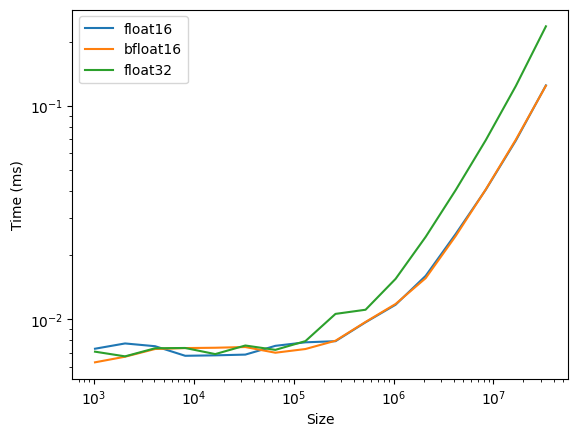

In [11]:
import numpy as np
import matplotlib.pyplot as plt

dtype_map = {
    'float32': torch.float32,
    'float16': torch.float16,
    'bfloat16': torch.bfloat16
}
def benchmark_add(size, dtype):
    """
    Benchmark the performance of vector addition with different data types.
    Args:
        size: the size of the input tensor.
        dtype: the data type of the input tensor (float32, float16 or bfloat16)
    Returns:
        The mean execution time.
    """
    print(f"testing size {size}")
    x = torch.rand(size, device='cuda', dtype=dtype_map[dtype])
    y = torch.rand(size, device='cuda', dtype=dtype_map[dtype])
    return triton.testing.do_bench(lambda: add(x, y))

for dtype in ['float16', 'bfloat16', 'float32']:
    print(f"benchmarking {dtype}")
    x_vals = [2 ** k for k in range(10, 26)]
    ms = np.array([benchmark_add(x, dtype) for x in x_vals])
    plt.plot(x_vals, ms, label=dtype)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Size')
plt.ylabel('Time (ms)')
plt.legend()

## Section 3. Logistic Map

The logistic map is one of the most famous examples in dynamical systems and chaos theory. It is defined by
$$
    f_r: [0, 1] \to [0, 1], x \mapsto rx(1-x),
$$
where $r \in [0, 4]$ is a parameter. Despite its simple quadratic form, iterating this map produces remarkably rich behavior. 

Want to see what this “rich behavior” looks like? Implement a Triton kernel that iterates the logistic map!

✓ Correctness test passed! Max difference: 0.00e+00


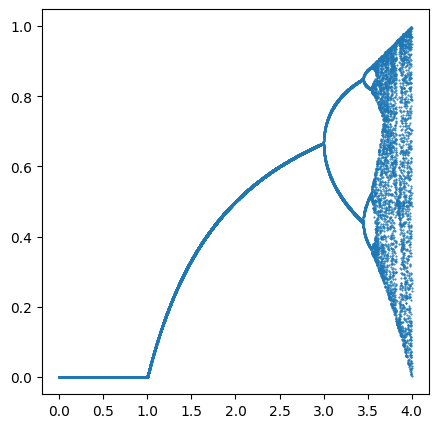

In [14]:
import triton
import triton.language as tl
from src.test_triton import check_same_tensor

def logistic_map_torch(x: torch.Tensor, r: torch.Tensor, m: int):
    for _ in range(m):
        x = r * x * (1 - x)
    return x

@triton.jit
def logistic_map_kernel(x_ptr, r_ptr, output_ptr, n, m, SEGMENT_SIZE: tl.constexpr):
    pid = tl.program_id(axis = 0)
    segment_start = pid * SEGMENT_SIZE
    offsets = segment_start + tl.arange(0, SEGMENT_SIZE)
    mask = offsets < n
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0)
    r = tl.load(r_ptr + offsets, mask=mask, other=0.0)
    for _ in range(m):
        x = r * x * (1 - x)
    tl.store(output_ptr + offsets, x, mask=mask)

def logistic_map(x: torch.Tensor, r: torch.Tensor, m: int):
    output = torch.empty_like(x)
    assert x.is_cuda
    n = x.numel()
    grid = lambda meta: (triton.cdiv(n, meta['SEGMENT_SIZE']),)
    logistic_map_kernel[grid](x, r, output, n, m, SEGMENT_SIZE=1024)
    return output

size = 40470
x = torch.rand(size, device='cuda', dtype=torch.float32)
r = 4 * torch.rand(size, device='cuda', dtype=torch.float32)
m = 5
output_torch = logistic_map_torch(x, r, m)
output_triton = logistic_map(x, r, m)

check_same_tensor(output_torch, output_triton)

plt.figure(figsize=(5, 5))
plt.plot(r.cpu(), logistic_map(x, r, 1000).cpu(), '.', markersize=1)

For those puzzled by the image: go read some books on chaos theory!

Now, copy and paste your code below, and decorate your function with `tl.autotune` to tune the following parameters automatically:
* `SEGMENT_SIZE`: $[64, 128, 256, 512, 1024]$.
* `num_warps`: $[2, 4, 8]$.

Benchmark the performances of torch, triton (without autotune) and triton (with autotune). Do not include the compilation time.

benchmarking torch
benchmarking triton
benchmarking triton-autotune


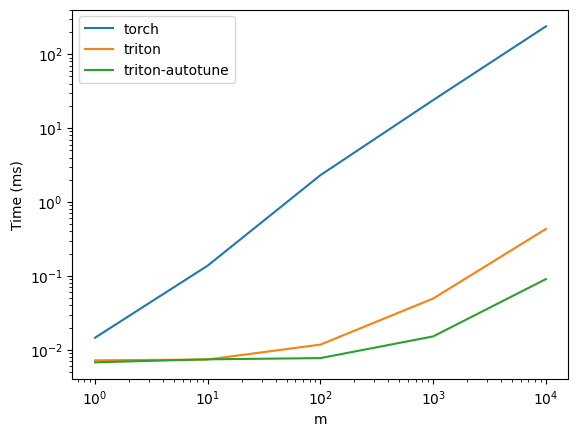

In [16]:
import numpy as np
import matplotlib.pyplot as plt

@triton.autotune(
    configs=[
        triton.Config({"SEGMENT_SIZE": s}, num_warps=w)
        for s in [64, 128, 256, 512, 1024]
        for w in [2, 4, 8]
    ],
    key=['n', 'm']
)
@triton.jit
def logistic_map_kernel_with_autotune(x_ptr, r_ptr, output_ptr, n, m, SEGMENT_SIZE: tl.constexpr):
    pid = tl.program_id(axis = 0)
    segment_start = pid * SEGMENT_SIZE
    offsets = segment_start + tl.arange(0, SEGMENT_SIZE)
    mask = offsets < n
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0)
    r = tl.load(r_ptr + offsets, mask=mask, other=0.0)
    for _ in range(m):
        x = r * x * (1 - x)
    tl.store(output_ptr + offsets, x, mask=mask)

def logistic_map_with_autotune(x: torch.Tensor, r: torch.Tensor, m: int):
    output = torch.empty_like(x)
    assert x.is_cuda
    n = x.numel()
    grid = lambda meta: (triton.cdiv(n, meta['SEGMENT_SIZE']),)
    logistic_map_kernel_with_autotune[grid](x, r, output, n, m)
    return output


@torch.no_grad()
def benchmark_logistic_map(size, m, provider):
    """
    Benchmark the performance of logistic map with different providers.
    Args:
        size: the size of the input tensor.
        m: the number of iterations.
        provider: ['torch', 'triton', 'triton-autotune']
    Returns:
        The mean execution time.
    """
    func = {
        'torch': logistic_map_torch,
        'triton': logistic_map,
        'triton-autotune': logistic_map_with_autotune
    }[provider]
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    r = 4 * torch.rand(size, device='cuda', dtype=torch.float32)
    return triton.testing.do_bench(lambda: func(x, r, m))

for provider in ['torch', 'triton', 'triton-autotune']:
    print(f"benchmarking {provider}")
    m_vals = [10 ** k for k in range(5)]
    ms = np.array([benchmark_logistic_map(5000, m, provider) for m in m_vals])
    plt.plot(m_vals, ms, label=provider)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('m')
plt.ylabel('Time (ms)')
plt.legend()

## Section 4. Roofline Model

In this section, we measure the throughput of our logistic map kernel and show that it follows a roofline model.

- **Arithmetic Intensity (AI)**: The number of FLOPs performed per byte moved, AI = FLOPs / Bytes.
- **Bandwidth Roof**: At low AI, performance is limited by memory bandwidth, so Perf ≈ Bandwidth × AI.
- **Compute Roof**: At high AI, performance is limited by the device's peak compute throughput (in TFLOPs).

Please use the following estimates for one iteration of logistic map (`x = r * x * (1 - x)`):
- **FLOPs per element**: 1 subtraction + 2 multiplications = 3 FLOPs/element.
- **Memory traffic (float32)**: read `x`, read `r`, write `x` ≈ 3 values × 4 bytes = 12 bytes/element.

Plot the throughput against arithmetic intensity.
* **x-axis**: arithmetic intensity (FLOPs/byte)
* **y-axis**: achieved throughput in TFLOPs (trillion FLOPs per second).

m=1: intensity=0.3333333333333333, tflops=0.43
m=2: intensity=0.6666666666666666, tflops=0.85
m=4: intensity=1.3333333333333333, tflops=1.70
m=8: intensity=2.6666666666666665, tflops=3.40
m=16: intensity=5.333333333333333, tflops=6.72
m=32: intensity=10.666666666666666, tflops=9.14
m=64: intensity=21.333333333333332, tflops=9.43
m=128: intensity=42.666666666666664, tflops=9.57
m=256: intensity=85.33333333333333, tflops=9.65
m=512: intensity=170.66666666666666, tflops=9.68
m=1024: intensity=341.3333333333333, tflops=9.70
m=2048: intensity=682.6666666666666, tflops=9.71
m=4096: intensity=1365.3333333333333, tflops=9.72
m=8192: intensity=2730.6666666666665, tflops=9.72
m=16384: intensity=5461.333333333333, tflops=9.72


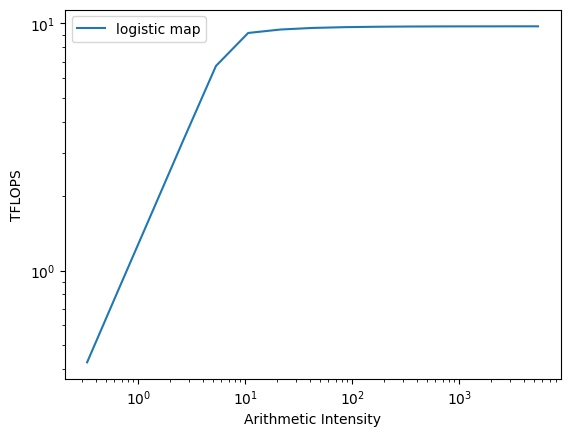

In [19]:
n = 40470533
m_vals = [2 ** k for k in range(15)]
ms = np.array([benchmark_logistic_map(n, m, 'triton') for m in m_vals])
xs = np.array(m_vals)

intensity_vals = xs / 3.0
tflops_vals = n * xs * 3.0 / ms / 1e9

plt.plot(intensity_vals, tflops_vals, label='logistic map')

for m, intensity, tflops in zip(m_vals, intensity_vals, tflops_vals):
    print(f'm={m}: intensity={intensity}, tflops={tflops:.2f}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Arithmetic Intensity')
plt.ylabel('TFLOPS')
plt.legend()

If you see a roofline, congratulations!!!

**Note:** the measured peak TFLOPs may differ from the theoretical peak computed in Section 1. This discrepancy is normal, as practical implementations incur various sources of overhead.